# Evaluation of HoVer-Net 

### Final Edit by Salma and Klara
27th of Feb

### validation set

In [164]:
!cat ../data/4_filelists/VALIDATION.txt

MFGTMPcx7_170702000001_B23f07d0.png
MFGTMPcx7_170702000001_F11f10d0.png
MFGTMPcx7_170702090001_A08f09d0.png
MFGTMPcx7_170702090001_A20f02d0.png
MFGTMPcx7_170702090001_G03f02d0.png
MFGTMPcx7_170702090001_K22f14d0.png
MFGTMPcx7_170702090001_P01f02d0.png
MFGTMPcx7_170731090001_A01f04d0.png
MFGTMPcx7_170731090001_B05f12d0.png
MFGTMPcx7_170802000001_I10f05d0.png


### test set

In [165]:
!cat ../data/4_filelists/TEST.txt

MFGTMPcx7_170702000001_G14f03d0.png
MFGTMPcx7_170702090001_B22f15d0.png
MFGTMPcx7_170702090001_C08f14d0.png
MFGTMPcx7_170702090001_H04f01d0.png
MFGTMPcx7_170702090001_P07f14d0.png
MFGTMPcx7_170731090001_B14f09d0.png
MFGTMPcx7_170731090001_D11f13d0.png
MFGTMPcx7_170731090001_I12f05d0.png
MFGTMPcx7_170801050001_G02f01d0.png
MFGTMPcx7_170803210001_J12f29d0.png


### Libraries

In [166]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb

import skimage.io
import skimage.morphology
import skimage.segmentation
from mat4py import loadmat

### Evalution metrics and functions

In [275]:
import numpy as np
import pandas as pd


def intersection_over_union(ground_truth, prediction):
    
    # Count objects
    true_objects = len(np.unique(ground_truth))
    pred_objects = len(np.unique(prediction))  
    
    # Compute intersection
    h = np.histogram2d(ground_truth.flatten(), prediction.flatten(), bins=(true_objects,pred_objects))
    intersection = h[0]
    
    # Area of objects
    area_true = np.histogram(ground_truth, bins=true_objects)[0]
    area_pred = np.histogram(prediction, bins=pred_objects)[0]
    
    # Calculate union
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)
    union = area_true + area_pred - intersection
    
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    
    # Compute Intersection over Union
    union[union == 0] = 1e-9
    IOU = intersection/union
    
    return IOU
    


def measures_at(threshold, IOU):
    
    matches = IOU > threshold
    
    true_positives = np.sum(matches, axis=1) == 1   # Correct objects
   
    false_negatives = np.sum(matches, axis=1) == 0  # Missed objects
    
    
    FP_matches = IOU > 0.5
    false_positives = np.sum(FP_matches, axis=0) == 0  # Extra objects
    
    assert np.all(np.less_equal(true_positives, 1))
    assert np.all(np.less_equal(false_positives, 1))
    assert np.all(np.less_equal(false_negatives, 1))
    
    TP, FP, FN = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
    
    f1 = 2*TP / (2*TP + FP + FN + 1e-9)
    
    return f1, TP, FP, FN

# Compute Average Precision for all IoU thresholds

def compute_af1_results(ground_truth, prediction, results, image_name):
   
    # Compute IoU
    IOU = intersection_over_union(ground_truth, prediction)
    if IOU.shape[0] > 0:
        jaccard = np.max(IOU, axis=0).mean()
    else:
        jaccard = 0.0
    
    # Calculate F1 score at all thresholds
    for t in np.arange(0.5, 1.0, 0.05):
        f1, tp, fp, fn = measures_at(t, IOU)
        res = {"Image": image_name, "Threshold": t, "F1": f1, "Jaccard": jaccard, "TP": tp, "FP": fp, "FN": fn}
        row = len(results)
        results.loc[row] = res
        
    return results

# Count number of False Negatives at 0.9 IoU

def get_false_negatives(ground_truth, prediction, results, image_name, threshold=0.9):
    
    # Compute IoU
    IOU = intersection_over_union(ground_truth, prediction)
    
    true_objects = len(np.unique(ground_truth))
    if true_objects <= 1:
        return results
        
    area_true = np.histogram(ground_truth, bins=true_objects)[0][1:]
    true_objects -= 1
    
    # Identify False Negatives
    matches = IOU > threshold
    false_negatives = np.sum(matches, axis=1) == 0  # Missed objects

    data = np.asarray([ 
        area_true.copy(), 
        np.array(false_negatives, dtype=np.int32)
    ])

    results = pd.concat([results, pd.DataFrame(data=data.T, columns=["Area", "False_Negative"])])
        
    return results

### WE changed the threshold of FP to 0.5
### This might change so many things
### So, the sum of TP and FP is not predicted objects since some objects are not FP and not also TP.
### FP is calculated from FN (0.9)

def get_false_positives(ground_truth, prediction, results, image_name, threshold=0.5):
    
    # Compute IoU
    IOU = intersection_over_union(ground_truth, prediction)
    
    pred_objects = len(np.unique(prediction))
    if pred_objects <= 1:
        return results
        
    area_pred = np.histogram(prediction, bins = pred_objects)[0][1:]
    pred_objects -= 1
    # Identify False Positives
    matches = IOU > threshold
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    
    data = np.asarray([ 
        area_pred.copy(), 
        np.array(false_positives, dtype=np.int32)
    ])

    results = pd.concat([results, pd.DataFrame(data=data.T, columns=["Area", "False_Positive"])])
        
    return results

### I have added this here to calculate the area of all gold objects

def get_gold_objects(ground_truth, prediction, results, image_name):
    
    
    true_objects = len(np.unique(ground_truth))
    if true_objects <= 1:
        return results
    
    area_true = np.histogram(ground_truth, bins=true_objects)[0][1:]
    
    true_objects -= 1
    
    
    data = np.asarray([ 
        np.arange(true_objects),
        area_true.copy()])
   
    results = pd.concat([results, pd.DataFrame(data=data.T, columns=["Gold_Object", "Area"])])
        
    return results


## This is for calculating the area of all predicted objects
def get_predicted_objects(ground_truth, prediction, results, image_name):
    
    
    pred_objects = len(np.unique(prediction))
    if pred_objects <= 1:
        return results
    
    area_pred = np.histogram(prediction, bins=pred_objects)[0][1:]
    
    pred_objects -= 1
    
    
    data = np.asarray([ 
        np.arange(pred_objects),
        area_pred.copy()])
   
    results = pd.concat([results, pd.DataFrame(data=data.T, columns=["Pred_Object", "Area"])])
        
    return results

# Count the number of splits and merges
def get_splits_and_merges(ground_truth, prediction, results, image_name):

    # Compute IoU
    IOU = intersection_over_union(ground_truth, prediction)
    
    matches = IOU > 0.1
    merges = np.sum(matches, axis=0) > 1
    splits = np.sum(matches, axis=1) > 1
    r = {"Image_Name":image_name, "Merges":np.sum(merges), "Splits":np.sum(splits)}
    results.loc[len(results)+1] = r
    return results

### Auxiliary visualization function

In [168]:
# Display prediction along with segmentation to visualize errors

def show(ground_truth, prediction, threshold=0.9, image_name="N"):
    
    # Compute Intersection over Union
    IOU = intersection_over_union(ground_truth, prediction)
    
    # Create diff map
    diff = np.zeros(ground_truth.shape + (3,))
    A = ground_truth.copy()
    B = prediction.copy()
    A[A > 0] = 1
    B[B > 0] = 1
    D = A - B
    #diff[D > 0,:2] = 1
    #diff[D < 0,1:] = 1
    
    # Object-level errors
    C = IOU.copy()
    C[C>=threshold] = 1
    C[C<threshold] = 0
    extra = np.where(np.sum(C,axis=0) == 0)[0]
    
    
    ### We changed the threshold of FP to 0.5 even here in show function
    FP_threshold = 0.5
    P = IOU.copy()
    P[P>=FP_threshold] = 1
    P[P<FP_threshold] = 0
    missed = np.where(np.sum(P,axis=1) == 0)[0]
    
    print()
    print('missed: '+str(missed))
    print()
    print('extra: '+str(extra))

    for m in missed:
        diff[ground_truth == m+1, 0] = 1
    for e in extra:
        diff[prediction == e+1, 2] = 1
    
    # Display figures
    fig, ax = plt.subplots(1, 3, figsize=(25,10))
    ax[0].imshow(ground_truth)
    ax[0].set_title("True objects:"+str(len(np.unique(ground_truth))-1))# correction corr script: -1
    ax[1].imshow(diff)
    ax[1].set_title("Segmentation errors (missed):"+str(len(missed)))
    ax[2].imshow(prediction)
    ax[2].set_title("Predicted objects:"+str(len(np.unique(prediction))-1))# correction corr script: -1
    #ax[3].imshow(IOU)
    #ax[3].set_title(image_name)

# Run the evaluation

## This part is for evaluating hovernet models  from  17, 23, and 37.

In [276]:
all_images = os.listdir('/proj/berzelius-2021-21/users/klara/Segmentation/hovernet/dataset/Test/images/')
all_images

['MFGTMPcx7_170702000001_G14f03d0.png',
 'MFGTMPcx7_170731090001_D11f13d0.png',
 'MFGTMPcx7_170702090001_B22f15d0.png',
 'MFGTMPcx7_170801050001_G02f01d0.png',
 'MFGTMPcx7_170702090001_H04f01d0.png',
 'MFGTMPcx7_170702090001_C08f14d0.png',
 'MFGTMPcx7_170731090001_B14f09d0.png',
 'MFGTMPcx7_170731090001_I12f05d0.png',
 'MFGTMPcx7_170803210001_J12f29d0.png',
 'MFGTMPcx7_170702090001_P07f14d0.png']

### An example of hovernet output

../hovernet/dataset/Test/annotations/MFGTMPcx7_170702090001_P07f14d0.mat
dict_keys(['__header__', '__version__', '__globals__', 'inst_centroid', 'inst_map'])
(1104, 1104)


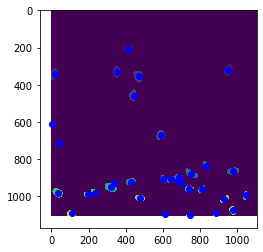

In [277]:
import scipy.io
pred_filename = os.path.join("../hovernet/dataset/Test/annotations/", all_images[-1])
print(pred_filename.replace('.png','.mat'))
prediction = scipy.io.loadmat(pred_filename.replace('.png','.mat'))
print(prediction.keys())
plt.imshow(prediction['inst_map'])
print(prediction['inst_map'].shape)
x = prediction['inst_centroid'][:,0]
y = prediction['inst_centroid'][:,1]
plt.scatter(x,y,c = 'blue')

## Run evaluation (17, 23, 37)

In [296]:
#all_images = data_partitions[partition]
from skimage.color import rgb2gray,rgb2lab

results = pd.DataFrame(columns=["Image", "Threshold", "F1", "Jaccard", "TP", "FP", "FN"])

false_negatives = pd.DataFrame(columns=["False_Negative", "Area"])
false_positives = pd.DataFrame(columns=["False_Positive", "Area"])
gold_obj = pd.DataFrame(columns=["Gold_Object", "Area"])  # for counting the area of gold objects
pred_obj = pd.DataFrame(columns=["Pred_Object", "Area"])  # for counting area of predicted objects
      
        
        
splits_merges = pd.DataFrame(columns=["Image_Name", "Merges", "Splits"])



for image_name in all_images:
    print(image_name)
    # Load ground truth data
    img_filename = os.path.join("../hovernet/dataset/Test/annotations", image_name)
    ground_truth = scipy.io.loadmat(img_filename.replace('.png','.mat'))['inst_map']#skimage.io.imread(img_filename)
    #ground_truth = ground_truth.squeeze()
    
    if len(ground_truth.shape) == 3:
        ground_truth = rgb2lab(ground_truth)
        ground_truth = ground_truth[:,:,0]
    
    ground_truth = skimage.morphology.label(ground_truth)
    
    
    # Load predictions
    pred_filename = os.path.join("../hovernet/output_test/37_out/mat", image_name) #again not sure
    prediction = scipy.io.loadmat(pred_filename.replace('.png','.mat'))['inst_map']
    
    
    if len(prediction.shape) == 3:
        prediction = rgb2lab(prediction)
        prediction = prediction[:,:,0]
    
        
    ####################################################################################    
    #### Testing prediction with no small objects on annot and prediction #####
    ground_truth = skimage.morphology.remove_small_objects(ground_truth, min_size=10)##min is 25 
    prediction = skimage.morphology.remove_small_objects(prediction, min_size=10)
    #####################################################################################
    
    # Relabel objects (cut margin of 30 pixels to make a fair comparison with DeepCell)
    ground_truth = skimage.segmentation.relabel_sequential(ground_truth)[0] #[30:-30,30:-30])[0]
    prediction = skimage.segmentation.relabel_sequential(prediction)[0] #[30:-30,30:-30])[0]
  
    # Compute evaluation metrics
    results = compute_af1_results(
        ground_truth, 
        prediction, 
        results, 
        image_name
    )
    
    false_negatives = get_false_negatives(
        ground_truth, 
        prediction, 
        false_negatives, 
        image_name
    )
    
    false_positives = get_false_positives(
        ground_truth, 
        prediction, 
        false_positives, 
        image_name
    )
    
    splits_merges = get_splits_and_merges(
        ground_truth, 
        prediction, 
        splits_merges, 
        image_name
    )
    
    gold_obj = get_gold_objects(
          ground_truth, 
          prediction, 
          gold_obj, 
          image_name
      )
    pred_obj = get_predicted_objects(
          ground_truth, 
          prediction, 
          pred_obj, 
          image_name
      )
    
   
    

MFGTMPcx7_170702000001_G14f03d0.png


/proj/berzelius-2021-21/users/Salma-files/envs/UNET_TF_1/lib/python3.6/site-packages/ipykernel_launcher.py:101: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/proj/berzelius-2021-21/users/Salma-files/envs/UNET_TF_1/lib/python3.6/site-packages/ipykernel_launcher.py:130: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



MFGTMPcx7_170731090001_D11f13d0.png
MFGTMPcx7_170702090001_B22f15d0.png
MFGTMPcx7_170801050001_G02f01d0.png
MFGTMPcx7_170702090001_H04f01d0.png
MFGTMPcx7_170702090001_C08f14d0.png
MFGTMPcx7_170731090001_B14f09d0.png
MFGTMPcx7_170731090001_I12f05d0.png
MFGTMPcx7_170803210001_J12f29d0.png
MFGTMPcx7_170702090001_P07f14d0.png


In [297]:
true_positive = false_negatives.copy()
true_positive

,Area,False_Negative
0,1781,0
1,1774,0
2,2395,0
3,1765,0
4,10,1
5,43,1
6,1621,0
7,1357,0
8,1152,0
9,1135,0


# Report of results

In [281]:
# Compute and print Average F1

average_F1_score = average_performance["F1"].mean()
jaccard_index = average_performance["Jaccard"].mean()
print("Average F1 score:", average_F1_score)
print("Jaccard index:", jaccard_index)

Average F1 score: 0.7929931194728106
Jaccard index: 0.8286224565136339


### The following cells are for categorizing the TP, FP, and FN objects size-wise

In [298]:
# Summarize False Negatives by area

false_negatives = false_negatives[false_negatives["False_Negative"] == 1]

false_negatives.groupby(
    pd.cut(
        false_negatives["Area"], 
        [0,100,1000,2100,30000], # Area intervals
        labels=["Tiny nuclei","Small nuclei","Normal nuclei","Large nuclei"],
    )
)["False_Negative"].sum()

Area
Tiny nuclei      46
Small nuclei     28
Normal nuclei    39
Large nuclei     13
Name: False_Negative, dtype: int64

In [299]:
falseP = false_positives[false_positives["False_Positive"] == 1]

FP_Area_chart = falseP.groupby(
    pd.cut(
        falseP["Area"], 
        [0,100,1000,2100,30000], # Area intervals
        labels=["Tiny nuclei","Small nuclei","Normal nuclei","Large nuclei"],
    )
)["False_Positive"].sum()

total_Positives = len(false_positives)
print(FP_Area_chart)

print("FDR Tiny:", "%.4f" % (FP_Area_chart["Tiny nuclei"]/total_Positives))

print("FDR Small:", "%.4f" % (FP_Area_chart["Small nuclei"]/total_Positives))

print("FDR Normal:", "%.4f" % (FP_Area_chart["Normal nuclei"]/total_Positives))

print("FDR Large:", "%.4f" % (FP_Area_chart["Large nuclei"]/total_Positives))


Area
Tiny nuclei       4
Small nuclei     29
Normal nuclei     3
Large nuclei      2
Name: False_Positive, dtype: int64
FDR Tiny: 0.0093
FDR Small: 0.0671
FDR Normal: 0.0069
FDR Large: 0.0046


In [300]:
# Summarize False Negatives by area

true_P = true_positive[true_positive["False_Negative"] == 0]

true_P['False_Negative'] = 1
TP_Area_chart = true_P.groupby(
    pd.cut(
        true_P["Area"], 
        [0,100,1000,2100,30000], # Area intervals
        labels=["Tiny nuclei","Small nuclei","Normal nuclei","Large nuclei"],
    )
)["False_Negative"].sum()
TP_Area_chart

/proj/berzelius-2021-21/users/Salma-files/envs/UNET_TF_1/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Area
Tiny nuclei        0
Small nuclei      13
Normal nuclei    236
Large nuclei      61
Name: False_Negative, dtype: int64

In [301]:
gold_obj['Gold_Obj'] = 1


GO_Area_chart = gold_obj.groupby(
    pd.cut(
        gold_obj["Area"], 
        [0,100,1000,2100,30000], # Area intervals
        labels=["Tiny nuclei","Small nuclei","Normal nuclei","Large nuclei"],
    )
)['Gold_Obj'].sum()


print(GO_Area_chart.sum())

GO_Area_chart


436


Area
Tiny nuclei       46
Small nuclei      41
Normal nuclei    275
Large nuclei      74
Name: Gold_Obj, dtype: int64

In [286]:
# Summarize splits and merges

print("Splits:",np.sum(splits_merges["Splits"]))
print("Merges:",np.sum(splits_merges["Merges"]))

Splits: 8
Merges: 4


In [222]:
# Report false positives

print("Extra objects (false postives):",results[results["Threshold"].round(3) == 0.9].sum()["FP"])

Extra objects (false postives): 25


In [287]:
thresh = 0.9


FP = results[results["Threshold"].round(3) == thresh].sum()["FP"]
FN = results[results["Threshold"].round(3) == thresh].sum()["FN"]
TP = results[results["Threshold"].round(3) == thresh].sum()["TP"]
Total = FP + TP

print("Extra objects (false postives):",FP)

print("True positives:",TP)

print("Total objects:",Total)

print("False discovery rate:", FP/Total)

Extra objects (false postives): 37
True positives: 300
Total objects: 337
False discovery rate: 0.10979228486646884


# **EPOCHS COMPARISON**

In [302]:
#all_images = data_partitions[partition]


from skimage.color import rgb2gray,rgb2lab

epochs_results = pd.DataFrame(columns=["Average F1 Score", "Average Jaccard Index", "False Negatives", "False Positives", "True Positives", "Detected Objects", "False Discovery Rate"])
best_models = [17,23,37]
for epoch in best_models:

  print("################################################################")
  print("EPOCH", epoch)

  results = pd.DataFrame(columns=["Image", "Threshold", "F1", "Jaccard", "TP", "FP", "FN"])
  false_negatives = pd.DataFrame(columns=["False_Negative", "Area"])
  false_positives = pd.DataFrame(columns=["False_Positive", "Area"])
  gold_obj = pd.DataFrame(columns=["Gold_Object", "Area"])
  pred_obj = pd.DataFrame(columns=["Pred_Object", "Area"])
  splits_merges = pd.DataFrame(columns=["Image_Name", "Merges", "Splits"])

  for image_name in all_images:
      # Load ground truth data  
      img_filename = os.path.join("../hovernet/dataset/Test/annotations/", image_name)
      ground_truth = scipy.io.loadmat(img_filename.replace('.png','.mat'))['inst_map']#skimage.io.imread(img_filename)
      #ground_truth = ground_truth.squeeze()
      if len(ground_truth.shape) == 3:
        ground_truth = rgb2lab(ground_truth)
        ground_truth = ground_truth[:,:,0]
    
      ground_truth = skimage.morphology.label(ground_truth)
    
      
       # Load predictions
      pred_filename = os.path.join("../hovernet/output_test/",str(epoch)+"_out/mat/", image_name)
      prediction = scipy.io.loadmat(pred_filename.replace('.png','.mat'))['inst_map']
      
        
        
      gold_obj = get_gold_objects(
          ground_truth, 
          prediction, 
          gold_obj, 
          image_name
      )
      pred_obj = get_predicted_objects(
          ground_truth, 
          prediction, 
          pred_obj, 
          image_name
      )
   
      # Apply object dilation
      #if config_vars["object_dilation"] > 0:
      #    struct = skimage.morphology.square(config_vars["object_dilation"])
      #    prediction = skimage.morphology.dilation(prediction, struct)
      #elif config_vars["object_dilation"] < 0:
      #    struct = skimage.morphology.square(-config_vars["object_dilation"])
      #    prediction = skimage.morphology.erosion(prediction, struct)
          
      ####################################################################################    
      #### Testing prediction with no small objects on annot and prediction #####
      ground_truth = skimage.morphology.remove_small_objects(ground_truth, min_size=10) 
      prediction = skimage.morphology.remove_small_objects(prediction, min_size=10)
      #####################################################################################
      
      # Relabel objects (cut margin of 30 pixels to make a fair comparison with DeepCell)
      ground_truth = skimage.segmentation.relabel_sequential(ground_truth)[0] #[30:-30,30:-30])[0]
      prediction = skimage.segmentation.relabel_sequential(prediction)[0] #[30:-30,30:-30])[0]
      
      
      # Compute evaluation metrics
      results = compute_af1_results(
          ground_truth, 
          prediction, 
          results, 
          image_name
      )
      
      false_negatives = get_false_negatives(
          ground_truth, 
          prediction, 
          false_negatives, 
          image_name
      )
      
      false_positives = get_false_positives(
          ground_truth, 
          prediction, 
          false_positives, 
          image_name
      )
      
      splits_merges = get_splits_and_merges(
          ground_truth, 
          prediction, 
          splits_merges, 
          image_name
      )
      
      
      
      
      # Display an example image
      #if image_name == all_images[0]:
      #show(ground_truth, prediction, image_name=image_name)


  # Display accuracy results
  
  average_performance = results.groupby("Threshold").mean().reset_index()
 
  
  R = results.groupby("Image").mean().reset_index()
  #g = sb.jointplot(data=R[R["F1"] > 0.4], x="Jaccard", y="F1")

  #average_performance
  R.sort_values(by="F1",ascending=False)

  # Plot accuracy results

  #sb.regplot(data=average_performance, x="Threshold", y="F1", order=3, ci=None)
  print(average_performance)


  # Compute and print Average F1

  F1_score_90 = average_performance["F1"][8] # I want only 90%
 
  #average_performance["F1"].mean()
  jaccard_index = average_performance["Jaccard"].mean()
  print("Average F1 score:", F1_score_90 )
  print("Jaccard index:", jaccard_index)


  # calculate true postives and false positives
  thresh = 0.9

  FP = results[results["Threshold"].round(3) == thresh].sum()["FP"]
  TP = results[results["Threshold"].round(3) == thresh].sum()["TP"]
  FN = results[results["Threshold"].round(3) == thresh].sum()["FN"]
  Total = FP + TP

  print("False negatives:",FN)
  print("False postives:",FP)
  print("True positives:",TP)

  print("Total objects:",Total)

  print("False discovery rate:", FP/Total)

  epochs_results.loc[epoch] = [F1_score_90 , jaccard_index, FN, FP, TP, Total, FP/Total]

  print('#############################################')

################################################################
EPOCH 17


/proj/berzelius-2021-21/users/Salma-files/envs/UNET_TF_1/lib/python3.6/site-packages/ipykernel_launcher.py:101: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/proj/berzelius-2021-21/users/Salma-files/envs/UNET_TF_1/lib/python3.6/site-packages/ipykernel_launcher.py:130: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



   Threshold        F1   Jaccard
0       0.50  0.886178  0.826874
1       0.55  0.886178  0.826874
2       0.60  0.873147  0.826874
3       0.65  0.867215  0.826874
4       0.70  0.848312  0.826874
5       0.75  0.835873  0.826874
6       0.80  0.831421  0.826874
7       0.85  0.810015  0.826874
8       0.90  0.755050  0.826874
9       0.95  0.321345  0.826874
Average F1 score: 0.7550501665702604
Jaccard index: 0.826874456718877
False negatives: 136
False postives: 37
True positives: 300
Total objects: 337
False discovery rate: 0.10979228486646884
#############################################
################################################################
EPOCH 23
   Threshold        F1   Jaccard
0       0.50  0.879203  0.817978
1       0.55  0.879203  0.817978
2       0.60  0.868618  0.817978
3       0.65  0.864174  0.817978
4       0.70  0.850574  0.817978
5       0.75  0.837782  0.817978
6       0.80  0.826286  0.817978
7       0.85  0.811403  0.817978
8       0.90  0.748725  0.817

In [303]:
epochs_results.rename(columns={'Average F1 Score':'F1_score_90'},inplace=True)
epochs_results['Precision']=epochs_results['True Positives']/(epochs_results['False Positives']+epochs_results['True Positives'])
epochs_results['Recall']=epochs_results['True Positives']/(epochs_results['False Negatives']+epochs_results['True Positives'])

epochs_results

,F1_score_90,Average Jaccard Index,False Negatives,False Positives,True Positives,Detected Objects,False Discovery Rate,Precision,Recall
17,0.755050,0.826874,136.0,37.0,300.0,337.0,0.109792,0.890208,0.688073
23,0.748725,0.817978,135.0,44.0,301.0,345.0,0.127536,0.872464,0.690367
37,0.772469,0.831041,126.0,38.0,310.0,348.0,0.109195,0.890805,0.711009
